In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input,GlobalMaxPool1D,Dropout
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input,GlobalMaxPool1D,Dropout,concatenate
from tensorflow.keras.models import Model

import nltk
import re
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

In [2]:
# Load train data
train = pd.read_csv('/content/drive/MyDrive/DATASETS/train.csv')
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [8]:
train['text'] = train['text'].replace(np.nan, train['title'])
train['title'] = train['title'].replace(np.nan, train['text'])
train.isnull().sum()

id           0
title        0
author    1957
text         0
label        0
dtype: int64

In [9]:
X_train=train.drop('label',axis=1)
y_train=train['label']

In [10]:
vo_size=500
messages=X_train.copy()
messages.reset_index(inplace=True)

In [14]:
ps_title =PorterStemmer()
ps_text =PorterStemmer()
corpus_title = []
corpus_text = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    
    #preproc title
    review = re.sub('[^a-zA-Z]', ' ',messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps_title.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_title.append(review)
    
    #preproc text
    review = re.sub('[^a-zA-Z]', ' ',messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps_text.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_text.append(review)

In [15]:
onehot_rep_title = [one_hot(words, vo_size) for words in corpus_title]
onehot_rep_text = [one_hot(words, vo_size) for words in corpus_text]

In [16]:
sent_length_title = 20
sent_length_text = 1000
embedded_doc_title=pad_sequences(onehot_rep_title, padding='pre', maxlen=sent_length_title)
embedded_doc_text=pad_sequences(onehot_rep_text, padding='pre', maxlen=sent_length_text)

In [17]:
print(len(embedded_doc_title),y_train.shape)
print(len(embedded_doc_text),y_train.shape)

20800 (20800,)
20800 (20800,)


In [18]:
X_final_title=np.array(embedded_doc_title)
X_final_text=np.array(embedded_doc_text)
y_final=np.array(y_train)
print(X_final_title.shape,y_final.shape)
print(X_final_text.shape,y_final.shape)

(20800, 20) (20800,)
(20800, 1000) (20800,)


In [34]:
#perform 80 is to 20 split manually
split = int(20800*0.8)


X_train_title = X_final_title[:split,:]
X_train_text = X_final_text[:split,:]
X_test_title = X_final_title[split:,:]
X_test_text =  X_final_text[split:,:]
y_train = y_final[:split]
y_test = y_final[split:]

print(X_train_title.shape,y_train.shape)
print(X_train_text.shape, y_train.shape)
print(X_test_title.shape,y_test.shape)
print(X_test_text.shape,y_test.shape)

(16640, 20) (16640,)
(16640, 1000) (16640,)
(4160, 20) (4160,)
(4160, 1000) (4160,)


In [35]:
#MODEL

embedding_vector_feature_title = 10
embedding_vector_feature_text = 100

input_title = Input(shape=(sent_length_title,))
input_text = Input(shape=(sent_length_text,))

emb_title = Embedding(vo_size,embedding_vector_feature_title)(input_title)
lstm_title = LSTM(128, return_sequences=False)(emb_title)

emb_text = Embedding(vo_size,embedding_vector_feature_text)(input_text)
lstm_text = LSTM(128, return_sequences=True)(emb_text)
max_pool_text = GlobalMaxPool1D()(lstm_text)
dropout_1_text = Dropout(0.1)(max_pool_text)
dense_1_text = Dense(50, activation='relu')(dropout_1_text)
dropout_2_text = Dropout(0.1)(dense_1_text)

out = concatenate([lstm_title,dropout_2_text],axis=-1)
output=Dense(1, activation='sigmoid')(out)

model = Model(inputs=[input_title, input_text], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1000, 100)    50000       ['input_4[0][0]']                
                                                                                                  
 lstm_3 (LSTM)                  (None, 1000, 128)    117248      ['embedding_3[0][0]']            
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 128)         0           ['lstm_3[0][0]']                 
 MaxPooling1D)                                                                              

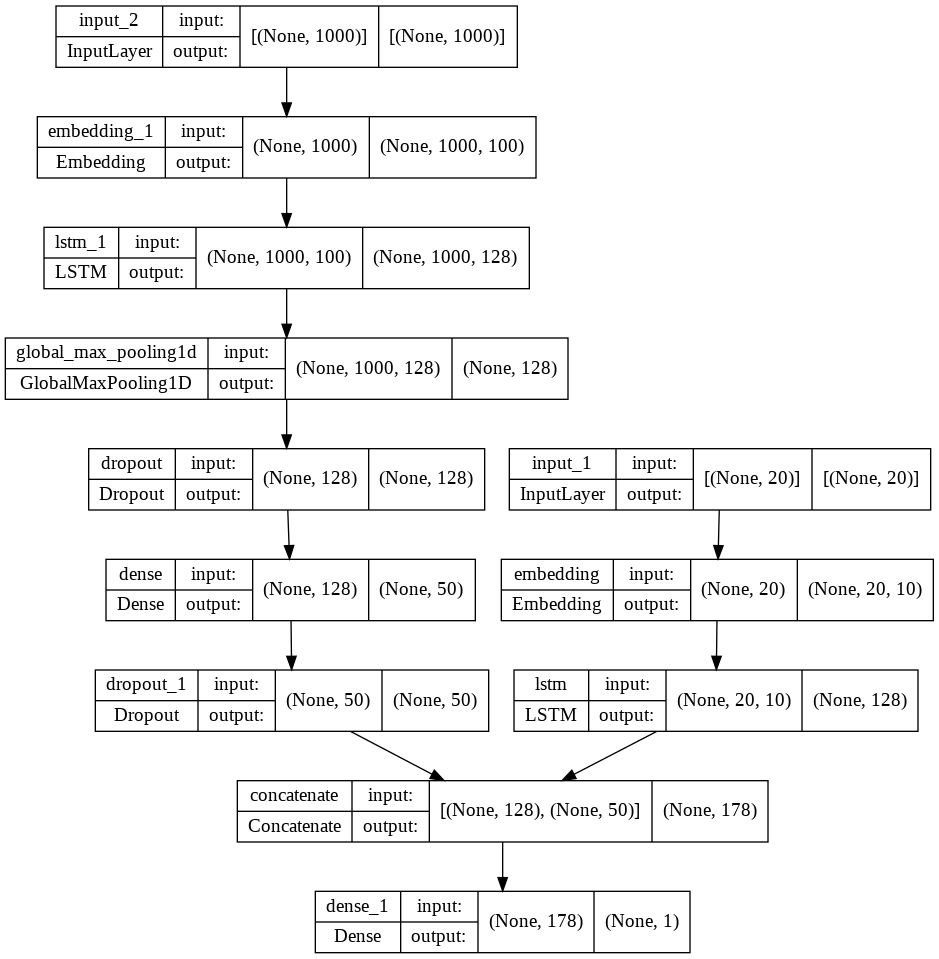

In [20]:
# Get model plot
plot_model(model, to_file='Fake_model_architecture.png', show_shapes=True, show_layer_names=True)

In [36]:
# train
history = model.fit(x=[X_train_title,X_train_text], y=y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
104/104 [==============================] - 30s 251ms/step - loss: 0.5645 - accuracy: 0.6952 - val_loss: 0.3284 - val_accuracy: 0.8465
Epoch 2/10
104/104 [==============================] - 25s 240ms/step - loss: 0.2016 - accuracy: 0.9195 - val_loss: 0.1917 - val_accuracy: 0.9228
Epoch 3/10
104/104 [==============================] - 25s 241ms/step - loss: 0.1181 - accuracy: 0.9537 - val_loss: 0.1319 - val_accuracy: 0.9468
Epoch 4/10
104/104 [==============================] - 25s 240ms/step - loss: 0.0883 - accuracy: 0.9667 - val_loss: 0.1210 - val_accuracy: 0.9519
Epoch 5/10
104/104 [==============================] - 24s 232ms/step - loss: 0.0761 - accuracy: 0.9727 - val_loss: 0.1217 - val_accuracy: 0.9513
Epoch 6/10
104/104 [==============================] - 24s 234ms/step - loss: 0.0607 - accuracy: 0.9782 - val_loss: 0.1399 - val_accuracy: 0.9552
Epoch 7/10
104/104 [==============================] - 25s 242ms/step - loss: 0.0511 - accuracy: 0.9828 - val_loss: 0.1380 - val_ac

In [22]:
# Save model
model.save_weights("Fake_News_FINAL_MODEL.h5")

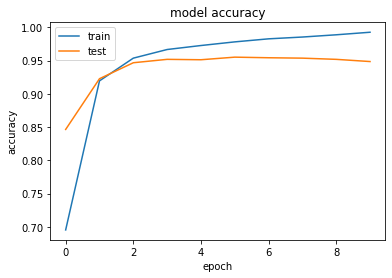

In [37]:
# Accuracy graph

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

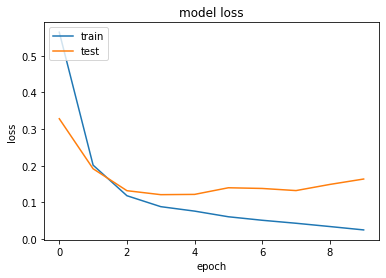

In [38]:
# Graph for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
y_pred=model.predict([X_test_title,X_test_text])

y_pred = (y_pred > 0.5)



In [40]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


from sklearn.metrics import accuracy_score

print("Model Accuracy:")
print(accuracy_score(y_test,y_pred))

print("Classification Report:")
print(classification_report(y_test,y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))

Model Accuracy:
0.9487980769230769
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2047
           1       0.96      0.93      0.95      2113

    accuracy                           0.95      4160
   macro avg       0.95      0.95      0.95      4160
weighted avg       0.95      0.95      0.95      4160

Confusion Matrix:
[[1973   74]
 [ 139 1974]]


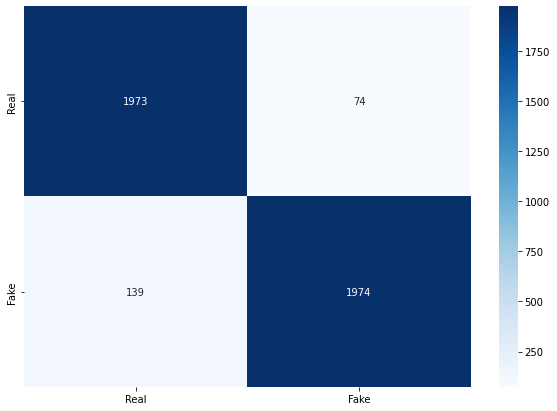

In [43]:

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(y_test,y_pred)

df_cm = pd.DataFrame(array, index = [i for i in ["Real","Fake"]],
                  columns = [i for i in ["Real","Fake"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, cmap='Blues',annot=True,fmt='g')
